# Computer Vision CSCI-GA.2272-001 Assignment 2

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

In [2]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

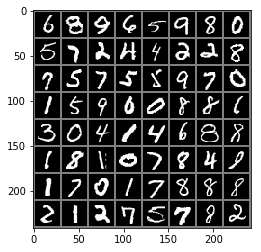

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.


(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


In [5]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [6]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # wrap inputs in Variable
        data, target = Variable(data.cuda()), Variable(target.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data.cuda(), volatile=True), Variable(target.cuda())
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [7]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.415998
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.727056
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.637259
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.539345
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.439485
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.679549
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.453782
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.483414
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.334545
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.339915

Test set: Average loss: 0.3971, Accuracy: 8929/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.394234
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.393688
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.406809
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.270912
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.348423
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.355276
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.344570
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.291086
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.820805
T

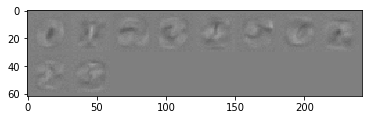

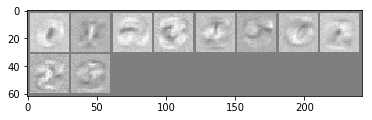

In [8]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28)))
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28),normalize=True, scale_each=True))        

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.


In [9]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    """Samples elements sequentially, always in the same order.
    Arguments:
        data_source (Dataset): dataset to sample from
        num_samples (int): number of samples to draw
    """

    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        if num_samples < len(self.data_source):
            self.num_samples = num_samples
        else:
            self.num_samples = len(self.data_source)
            
    def __iter__(self):
        return iter(range(self.num_samples))

    def __len__(self):
        return self.num_samples

In [10]:
subset_sampler = SubsetSampler(trainset, 50)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, sampler=subset_sampler, num_workers=0)
subset_sampler = SubsetSampler(testset, 50)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=subset_sampler, num_workers=0)

network = Net(num_inputs, num_outputs)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [11]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.517375

Test set: Average loss: 0.0120, Accuracy: 8/10000 (0%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.334054

Test set: Average loss: 0.0116, Accuracy: 9/10000 (0%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.240296

Test set: Average loss: 0.0113, Accuracy: 9/10000 (0%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.167956

Test set: Average loss: 0.0111, Accuracy: 10/10000 (0%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.101216

Test set: Average loss: 0.0109, Accuracy: 10/10000 (0%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.037231

Test set: Average loss: 0.0108, Accuracy: 13/10000 (0%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.975553

Test set: Average loss: 0.0106, Accuracy: 16/10000 (0%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.916083

Test set: Average loss: 0.0104, Accuracy: 17/10000 (0%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.858774

Test set: Average loss: 0.0103, Accuracy: 19/10000 (0%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 1.803580

Test set: Average loss: 0.010

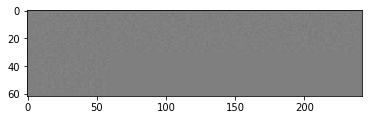

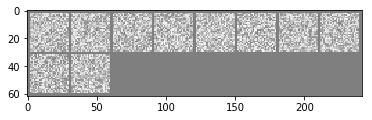

In [12]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28)))
        imshow(utils.make_grid(x.weight.data.cpu().view(10,1,28,28),normalize=True, scale_each=True))        

### Underfit 
Due to lack of data.................

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.


In [13]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

network = Net(num_inputs, num_outputs, hidden_units=1000)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [14]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346220
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.109523
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.702013
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.636294
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.580451
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.580909
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.556305
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.472102
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.333726
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.251488

Test set: Average loss: 0.3739, Accuracy: 8985/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.354283
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.241593
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.395487
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.445636
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.252181
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.277465
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.404850
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.301384
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.309324
T

-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

In [15]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

network = Net(num_inputs, num_outputs, hidden_units=1000)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=10)

In [16]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360404
Train Epoch: 1 [6400/60000 (11%)]	Loss: 4935.794922
Train Epoch: 1 [12800/60000 (21%)]	Loss: 5047.468262
Train Epoch: 1 [19200/60000 (32%)]	Loss: 5245.594727
Train Epoch: 1 [25600/60000 (43%)]	Loss: 6099.244141
Train Epoch: 1 [32000/60000 (53%)]	Loss: 4388.768555
Train Epoch: 1 [38400/60000 (64%)]	Loss: 4821.752441
Train Epoch: 1 [44800/60000 (75%)]	Loss: 4414.066895
Train Epoch: 1 [51200/60000 (85%)]	Loss: 6169.766113
Train Epoch: 1 [57600/60000 (96%)]	Loss: 4548.464355

Test set: Average loss: 4520.4038, Accuracy: 958/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 5165.601074
Train Epoch: 2 [6400/60000 (11%)]	Loss: 4598.265137
Train Epoch: 2 [12800/60000 (21%)]	Loss: 3673.232422
Train Epoch: 2 [19200/60000 (32%)]	Loss: 5045.183105
Train Epoch: 2 [25600/60000 (43%)]	Loss: 6317.142090
Train Epoch: 2 [32000/60000 (53%)]	Loss: 4306.087891
Train Epoch: 2 [38400/60000 (64%)]	Loss: 5518.575684
Train Epoch: 2 [44800/60000 (75%)]	Loss: 4021.28076

### Overshoot
.................................................

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

In [17]:
dataset = 'cifar10'
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.



In [18]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072


class Net(nn.Module):
    def __init__(self, num_channels, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.fc1 = nn.Linear(128 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
#         print(x.size())
        x = x.view(-1, 128 * 5 * 5)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

num_channels = iter(train_loader).next()[0].size()[1]
network = Net(num_channels, num_outputs=10)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.


In [19]:
epochs = 20

for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.297870
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.090785
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.047413
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.919259
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.794890
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.824302
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.873875
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.724898

Test set: Average loss: 1.8002, Accuracy: 18664/50000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.872226
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.673958
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.819389
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.706496
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.561394
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.611174
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.794991
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.557981

Test set: Average loss: 1.6124, Accuracy: 21463/50000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.553245
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.7


Test set: Average loss: 0.8833, Accuracy: 34493/50000 (69%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.846253
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.857657
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.947418
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.813192
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.929774
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.842750
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.683854
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.553013

Test set: Average loss: 0.8138, Accuracy: 36000/50000 (72%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.901788
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.610164
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.826060
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.805197
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.676299
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.842763
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.699617
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.882122

Test set: Average loss: 0.8128, Accuracy: 35843/50000 (72%)



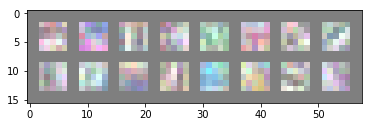

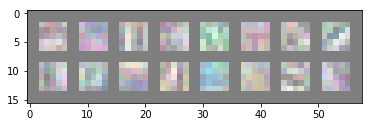

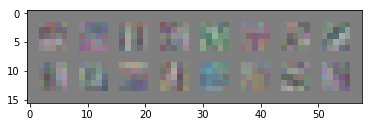

In [24]:
for x in network.modules():
    if isinstance(x, nn.Conv2d):
        imshow(utils.make_grid(x.weight.data.cpu(),normalize=True, scale_each=True))
        imshow(utils.make_grid(x.weight.data.cpu(),normalize=True))
        imshow(utils.make_grid(x.weight.data.cpu()))
        break

- Give a breakdown of the parameters within the above model, and the overall number.

Number of learnable parameters: ....

In [21]:
params = list(network.parameters())
print(len(params))
total_parameter_count = 0
for param in params:
    param_count = np.prod(param.size())
    total_parameter_count += param_count
    print(param.size())
print("Total number of parameters:", total_parameter_count)

8
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([128, 16, 5, 5])
torch.Size([128])
torch.Size([64, 3200])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
Total number of parameters: 258058
